In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(42)

In [2]:
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [3]:
def generate_linear_data(n_samples=100, n_features=3):
    X = np.random.uniform(-10, 10, size=(n_samples, n_features))
    coefficients = np.array([2.5, -1.5, 3.0])
    noise = np.random.normal(0, 5, size=n_samples)
    y = X @ coefficients + noise 
    return X, y

In [4]:
def generate_nonlinear_data(n_samples=100, n_features=3): 
    X = np.random.uniform(-10, 10, size=(n_samples, n_features))
    noise = np.random.normal(0, 10, size=n_samples)
    y = (X[:, 0]**2) + np.sin(X[:, 1]) + np.log(np.abs(X[:, 2]) + 1) + noise
    return X, y

In [5]:
X_linear, y_linear = generate_linear_data()
X_nonlinear, y_nonlinear = generate_nonlinear_data()

In [6]:
feature_names = [f'Feature_{i+1}' for i in range(X_linear.shape[1])]


In [7]:
df_linear = pd.DataFrame(X_linear, columns=feature_names)
df_linear['Target'] = y_linear

In [8]:
df_nonlinear = pd.DataFrame(X_nonlinear, columns=feature_names)
df_nonlinear['Target'] = y_nonlinear

In [9]:
print("Linear Dataset Sample:")
display(df_linear.head())

print("\nNonlinear Dataset Sample:")
display(df_nonlinear.head())

Linear Dataset Sample:


,Feature_1,Feature_2,Feature_3,Target
0,-2.509198,9.014286,4.639879,-5.646928
1,1.973170,-6.879627,-6.880110,-8.645966
2,-8.838328,7.323523,2.022300,-16.294483
3,4.161452,-9.588310,9.398197,56.150280
4,6.648853,-5.753218,-6.363501,-3.964256



Nonlinear Dataset Sample:


,Feature_1,Feature_2,Feature_3,Target
0,-8.848825,0.990578,-1.169390,91.590310
1,7.754084,-2.981700,-7.658660,64.669369
2,-7.140166,5.230213,2.364361,54.702342
3,-7.977546,-8.317864,4.019383,60.241463
4,-8.544740,6.437201,4.124845,69.924025


In [10]:
def split_data(X, y, test_size=0.2):
    return train_test_split(X, y, test_size=test_size, random_state=42)


In [11]:
X_train_linear, X_test_linear, y_train_linear, y_test_linear = split_data(X_linear, y_linear)
X_train_nonlinear, X_test_nonlinear, y_train_nonlinear, y_test_nonlinear = split_data(X_nonlinear, y_nonlinear)


In [12]:
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_nonlinear_poly = poly.fit_transform(X_train_nonlinear)
X_test_nonlinear_poly = poly.transform(X_test_nonlinear)

poly_feature_names = poly.get_feature_names_out(feature_names)
df_train_nonlinear_poly = pd.DataFrame(X_train_nonlinear_poly, columns=poly_feature_names)
df_test_nonlinear_poly = pd.DataFrame(X_test_nonlinear_poly, columns=poly_feature_names)

print("Polynomial Features Sample (Nonlinear Dataset):")
display(df_train_nonlinear_poly.head())


Polynomial Features Sample (Nonlinear Dataset):


,Feature_1,Feature_2,Feature_3,Feature_1^2,Feature_1 Feature_2,Feature_1 Feature_3,Feature_2^2,Feature_2 Feature_3,Feature_3^2
0,-6.961946,-7.223457,2.817495,48.468694,50.289315,-19.615248,52.178324,-20.352052,7.938277
1,5.389859,-6.259125,-3.526415,29.050576,-33.735799,-19.006880,39.176646,22.072274,12.435605
2,-3.809448,6.275900,3.694623,14.511892,-23.907714,-14.074475,39.386926,23.187089,13.650242
3,0.403270,7.043630,1.038137,0.162627,2.840485,0.418649,49.612724,7.312251,1.077728
4,7.904137,0.233549,0.642270,62.475378,1.846002,5.076588,0.054545,0.150001,0.412510


In [13]:
def create_knn_model(X_train, y_train):
    knn = KNeighborsRegressor()
    param_grid = {'n_neighbors': list(range(1, 21))}
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Optimal number of neighbors: {grid_search.best_params_['n_neighbors']}")
    return grid_search.best_estimator_


In [14]:
def create_dt_model(X_train, y_train):
    dt = DecisionTreeRegressor(random_state=42)
    param_grid = {'max_depth': list(range(1, 21))}
    grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    print(f"Optimal max_depth: {grid_search.best_params_['max_depth']}")
    return grid_search.best_estimator_

In [15]:
def train_models(X_train, y_train, dataset_type='Linear'):
    print(f"\n=== Training Models on {dataset_type} Dataset ===")
    
    linear = LinearRegression()
    linear.fit(X_train, y_train)
    print("Linear Regression trained.")
    
    knn = create_knn_model(X_train, y_train)
    
    dt = create_dt_model(X_train, y_train)
    
    return linear, knn, dt


In [16]:
def evaluate_model(model, X_train, y_train, X_test, y_test, dataset_type='Linear', model_name='Linear Regression'):
    metrics = {}
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    metrics['Train_MAE'] = mean_absolute_error(y_train, y_pred_train)
    metrics['Train_MSE'] = mean_squared_error(y_train, y_pred_train)
    metrics['Train_R2'] = r2_score(y_train, y_pred_train)
    
    metrics['Test_MAE'] = mean_absolute_error(y_test, y_pred_test)
    metrics['Test_MSE'] = mean_squared_error(y_test, y_pred_test)
    metrics['Test_R2'] = r2_score(y_test, y_pred_test)
    
    print(f"\n--- Evaluation Metrics for {dataset_type} Dataset using {model_name} ---")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    return y_pred_test, metrics


In [17]:
performance_metrics = {
    'Dataset': [],
    'Model': [],
    'Train_MAE': [],
    'Train_MSE': [],
    'Train_R2': [],
    'Test_MAE': [],
    'Test_MSE': [],
    'Test_R2': []
}

linear_models_linear, knn_models_linear, dt_models_linear = train_models(X_train_linear, y_train_linear, 'Linear')

y_pred_lin_lin, metrics_lin_lin = evaluate_model(linear_models_linear, X_train_linear, y_train_linear, X_test_linear, y_test_linear, 'Linear', 'Linear Regression')
performance_metrics['Dataset'].append('Linear')
performance_metrics['Model'].append('Linear Regression')
for key, value in metrics_lin_lin.items():
    performance_metrics[key].append(value)

y_pred_knn_lin, metrics_knn_lin = evaluate_model(knn_models_linear, X_train_linear, y_train_linear, X_test_linear, y_test_linear, 'Linear', 'KNN Regressor')
performance_metrics['Dataset'].append('Linear')
performance_metrics['Model'].append('KNN Regressor')
for key, value in metrics_knn_lin.items():
    performance_metrics[key].append(value)

y_pred_dt_lin, metrics_dt_lin = evaluate_model(dt_models_linear, X_train_linear, y_train_linear, X_test_linear, y_test_linear, 'Linear', 'Decision Tree Regressor')
performance_metrics['Dataset'].append('Linear')
performance_metrics['Model'].append('Decision Tree Regressor')
for key, value in metrics_dt_lin.items():
    performance_metrics[key].append(value)

linear_models_nl, knn_models_nl, dt_models_nl = train_models(X_train_nonlinear_poly, y_train_nonlinear, 'Nonlinear')

y_pred_lin_nl, metrics_lin_nl = evaluate_model(linear_models_nl, X_train_nonlinear_poly, y_train_nonlinear, X_test_nonlinear_poly, y_test_nonlinear, 'Nonlinear', 'Linear Regression')
performance_metrics['Dataset'].append('Nonlinear')
performance_metrics['Model'].append('Linear Regression')
for key, value in metrics_lin_nl.items():
    performance_metrics[key].append(value)

y_pred_knn_nl, metrics_knn_nl = evaluate_model(knn_models_nl, X_train_nonlinear_poly, y_train_nonlinear, X_test_nonlinear_poly, y_test_nonlinear, 'Nonlinear', 'KNN Regressor')
performance_metrics['Dataset'].append('Nonlinear')
performance_metrics['Model'].append('KNN Regressor')
for key, value in metrics_knn_nl.items():
    performance_metrics[key].append(value)

y_pred_dt_nl, metrics_dt_nl = evaluate_model(dt_models_nl, X_train_nonlinear_poly, y_train_nonlinear, X_test_nonlinear_poly, y_test_nonlinear, 'Nonlinear', 'Decision Tree Regressor')
performance_metrics['Dataset'].append('Nonlinear')
performance_metrics['Model'].append('Decision Tree Regressor')
for key, value in metrics_dt_nl.items():
    performance_metrics[key].append(value)



=== Training Models on Linear Dataset ===
Linear Regression trained.
Optimal number of neighbors: 3
Optimal max_depth: 5

--- Evaluation Metrics for Linear Dataset using Linear Regression ---
Train_MAE: 3.4698
Train_MSE: 17.5065
Train_R2: 0.9708
Test_MAE: 5.5219
Test_MSE: 50.4348
Test_R2: 0.9120

--- Evaluation Metrics for Linear Dataset using KNN Regressor ---
Train_MAE: 4.6206
Train_MSE: 30.1511
Train_R2: 0.9498
Test_MAE: 8.3129
Test_MSE: 98.7869
Test_R2: 0.8276

--- Evaluation Metrics for Linear Dataset using Decision Tree Regressor ---
Train_MAE: 3.1518
Train_MSE: 21.6989
Train_R2: 0.9639
Test_MAE: 10.8776
Test_MSE: 175.9244
Test_R2: 0.6930

=== Training Models on Nonlinear Dataset ===
Linear Regression trained.
Optimal number of neighbors: 4
Optimal max_depth: 3

--- Evaluation Metrics for Nonlinear Dataset using Linear Regression ---
Train_MAE: 7.5192
Train_MSE: 95.6348
Train_R2: 0.9212
Test_MAE: 8.7715
Test_MSE: 130.3549
Test_R2: 0.8865

--- Evaluation Metrics for Nonlinear Dat


=== Pair Plot for Linear Dataset ===


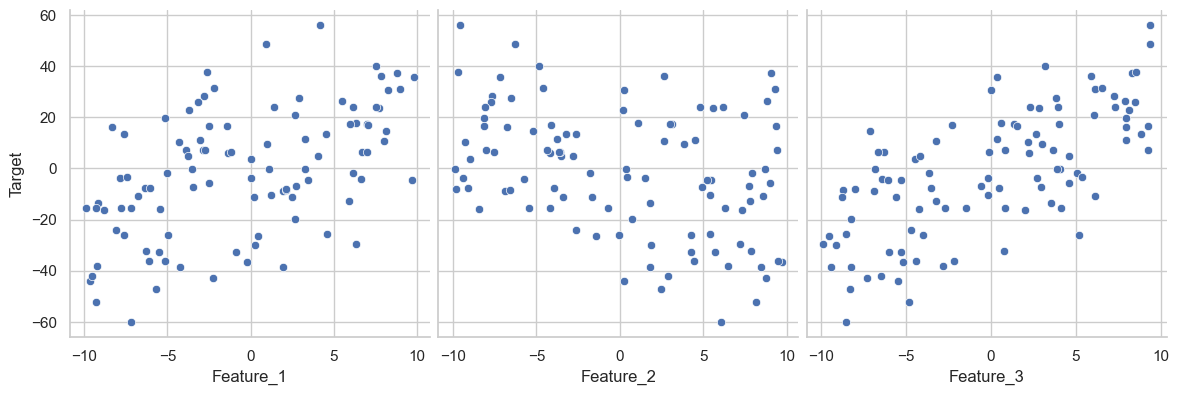


=== Pair Plot for Nonlinear Dataset ===


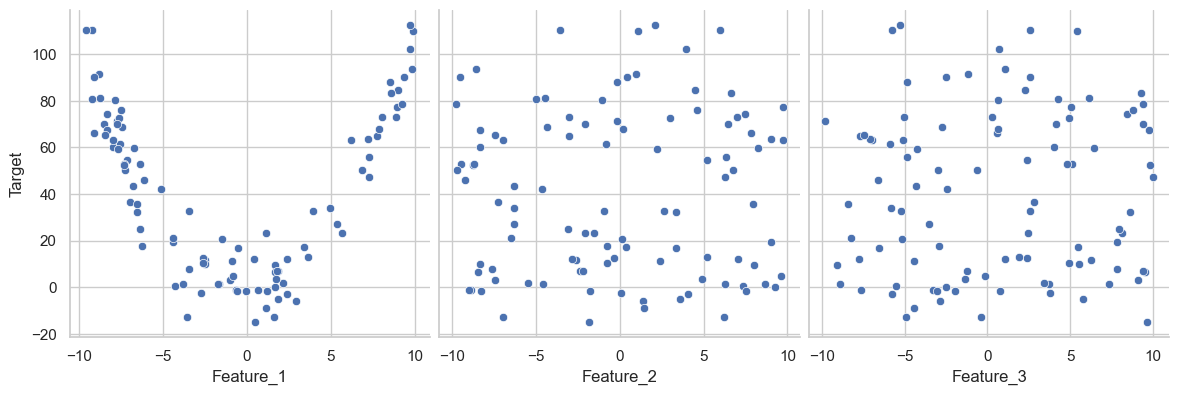

In [18]:
print("\n=== Pair Plot for Linear Dataset ===")
sns.pairplot(df_linear, x_vars=feature_names, y_vars='Target', height=4, aspect=1, kind='scatter')
plt.show()

print("\n=== Pair Plot for Nonlinear Dataset ===")
sns.pairplot(df_nonlinear, x_vars=feature_names, y_vars='Target', height=4, aspect=1, kind='scatter')
plt.show()



=== Correlation Heatmap for Linear Dataset ===


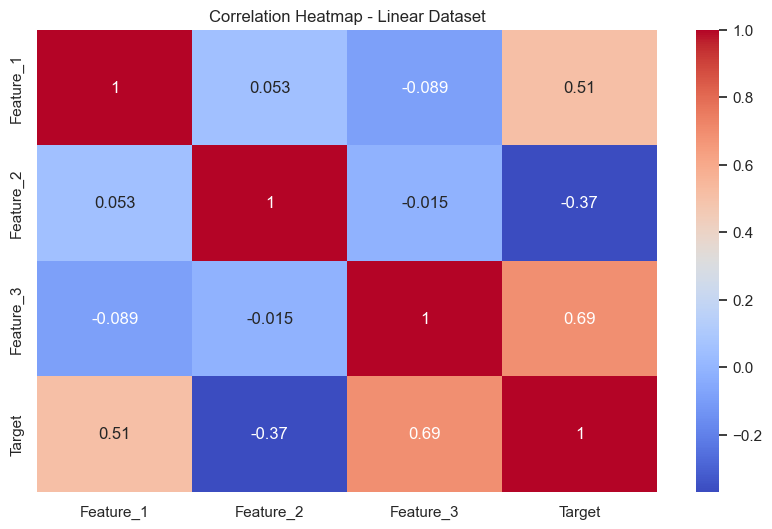


=== Correlation Heatmap for Nonlinear Dataset ===


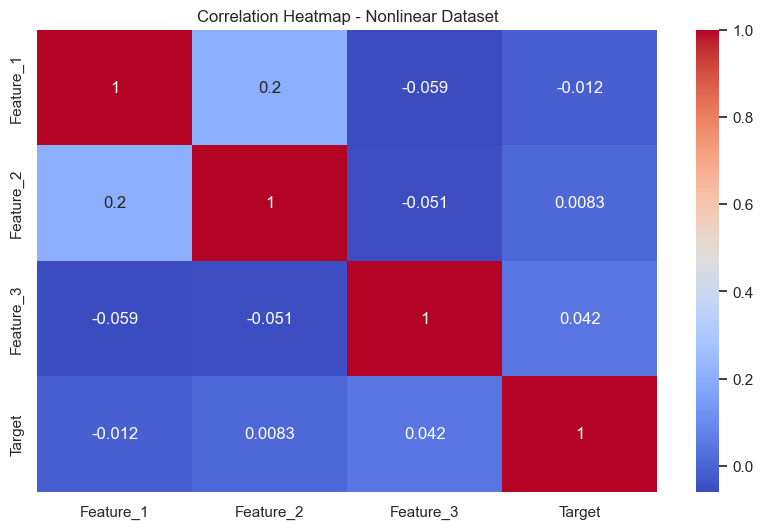

In [19]:
print("\n=== Correlation Heatmap for Linear Dataset ===")
corr_linear = df_linear.corr()
sns.heatmap(corr_linear, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Linear Dataset')
plt.show()

print("\n=== Correlation Heatmap for Nonlinear Dataset ===")
corr_nonlinear = df_nonlinear.corr()
sns.heatmap(corr_nonlinear, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap - Nonlinear Dataset')
plt.show()



=== Performance Metrics ===


,Dataset,Model,Train_MAE,Train_MSE,Train_R2,Test_MAE,Test_MSE,Test_R2
0,Linear,Linear Regression,3.469764,17.506518,0.970839,5.521900,50.434812,0.911992
1,Linear,KNN Regressor,4.620625,30.151124,0.949776,8.312862,98.786871,0.827618
2,Linear,Decision Tree Regressor,3.151797,21.698874,0.963855,10.877587,175.924428,0.693014
3,Nonlinear,Linear Regression,7.519228,95.634807,0.921193,8.771547,130.354859,0.886510
4,Nonlinear,KNN Regressor,9.577275,158.563551,0.869337,13.488216,355.193816,0.690759
5,Nonlinear,Decision Tree Regressor,6.562767,68.082062,0.943897,7.804486,107.171304,0.906694


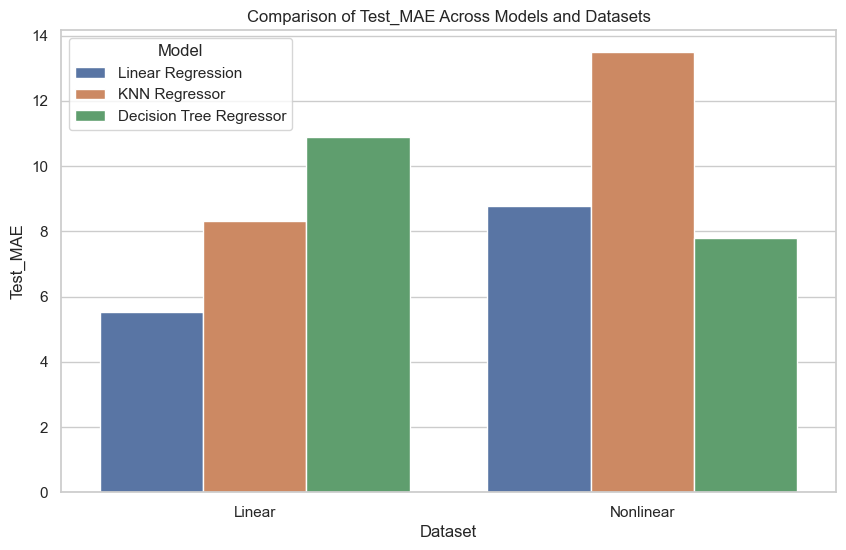

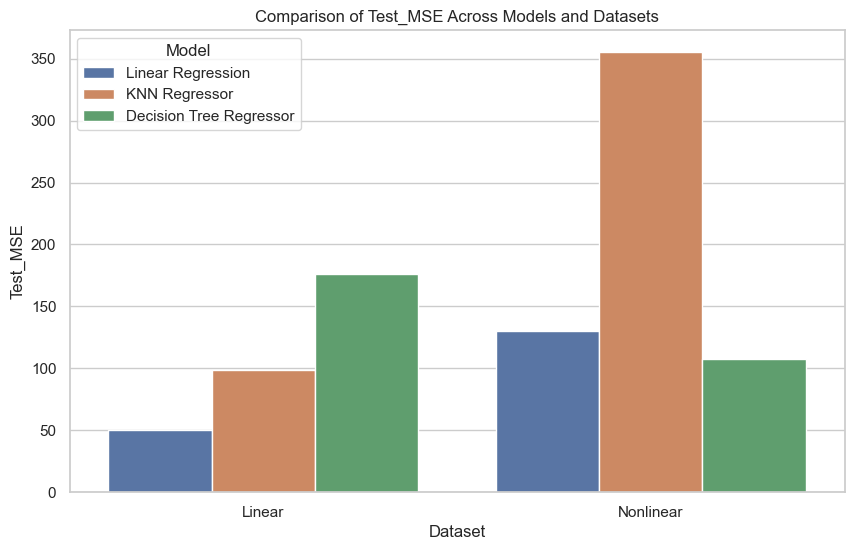

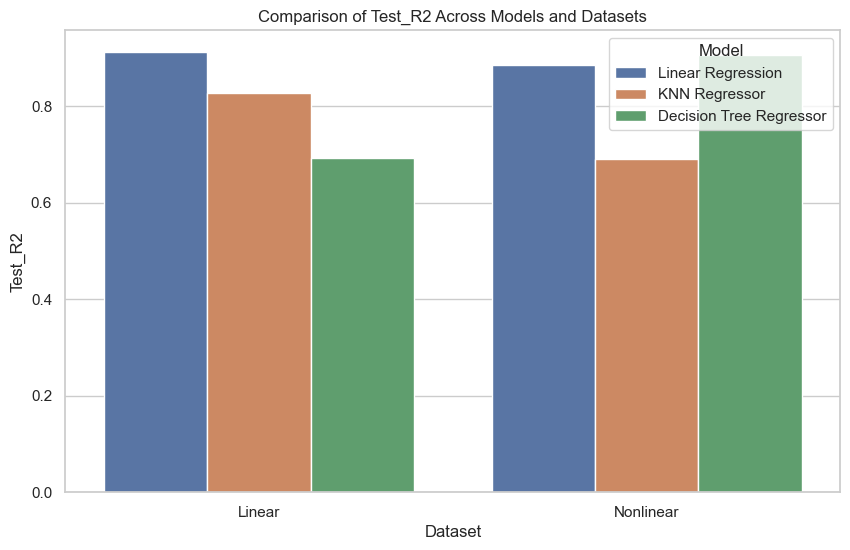

In [20]:
metrics_df = pd.DataFrame(performance_metrics)
print("\n=== Performance Metrics ===")
display(metrics_df)

metrics_to_plot = ['Test_MAE', 'Test_MSE', 'Test_R2']

for metric in metrics_to_plot:
    plt.figure(figsize=(10,6))
    sns.barplot(data=metrics_df, x='Dataset', y=metric, hue='Model')
    plt.title(f'Comparison of {metric} Across Models and Datasets')
    plt.ylabel(metric)
    plt.xlabel('Dataset')
    plt.legend(title='Model')
    plt.show()


In [21]:
def plot_learning_curves(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, scoring='neg_mean_squared_error', 
                                                            train_sizes=np.linspace(0.1, 1.0, 10), random_state=42)
    
    train_scores_mean = -train_scores.mean(axis=1)
    test_scores_mean = -test_scores.mean(axis=1)
    
    plt.figure(figsize=(10,6))
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training MSE')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validation MSE')
    plt.title(title)
    plt.xlabel('Training Size')
    plt.ylabel('Mean Squared Error')
    plt.legend(loc='best')
    plt.grid()
    plt.show()



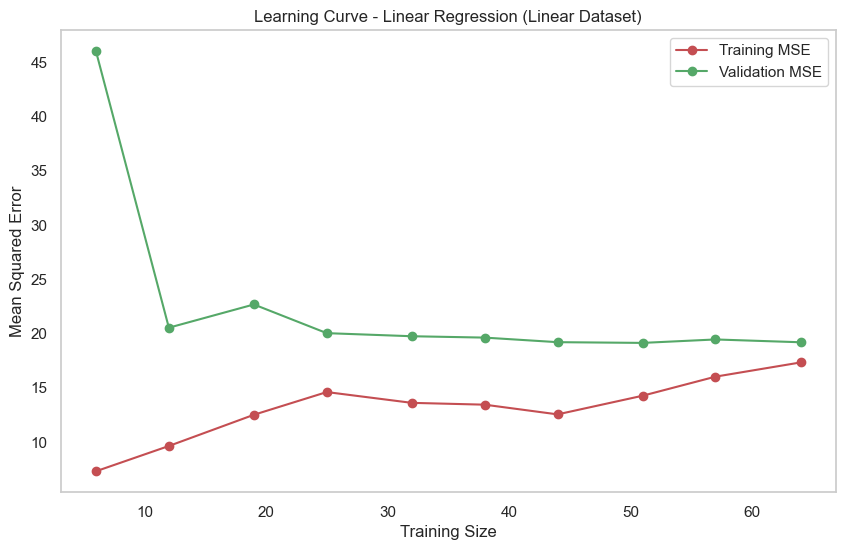

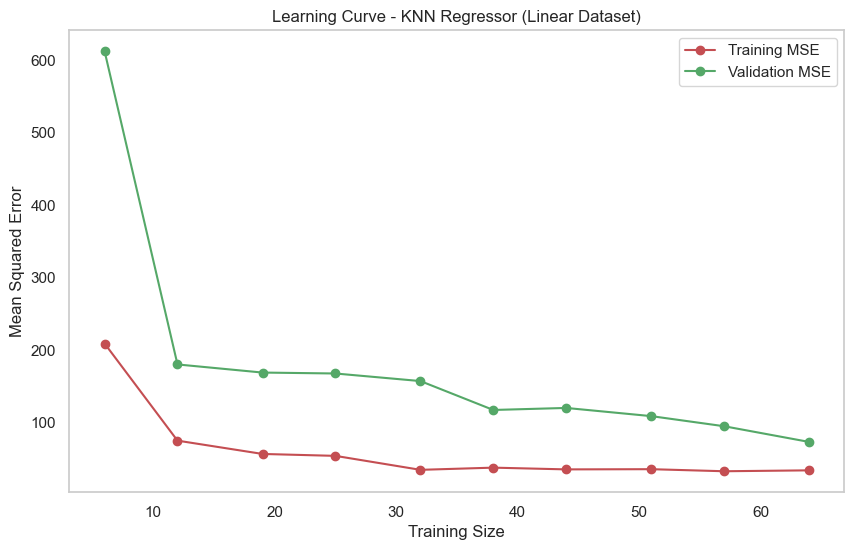

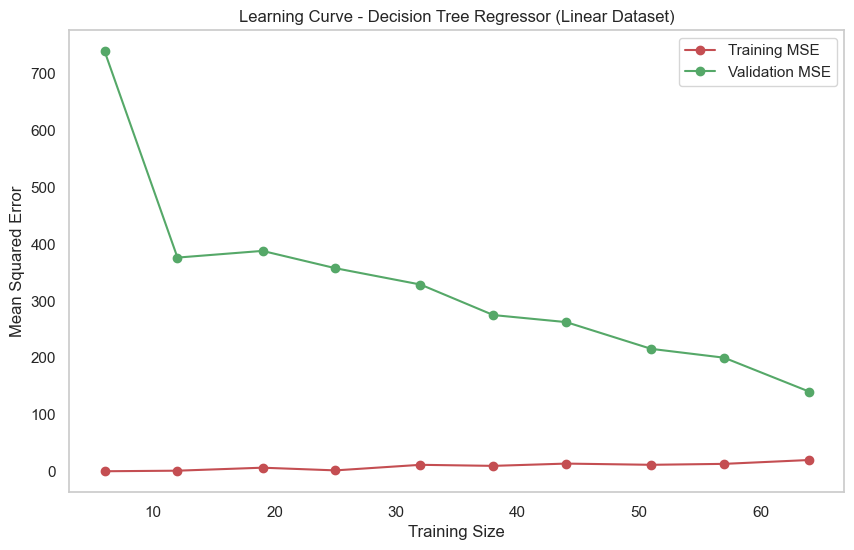

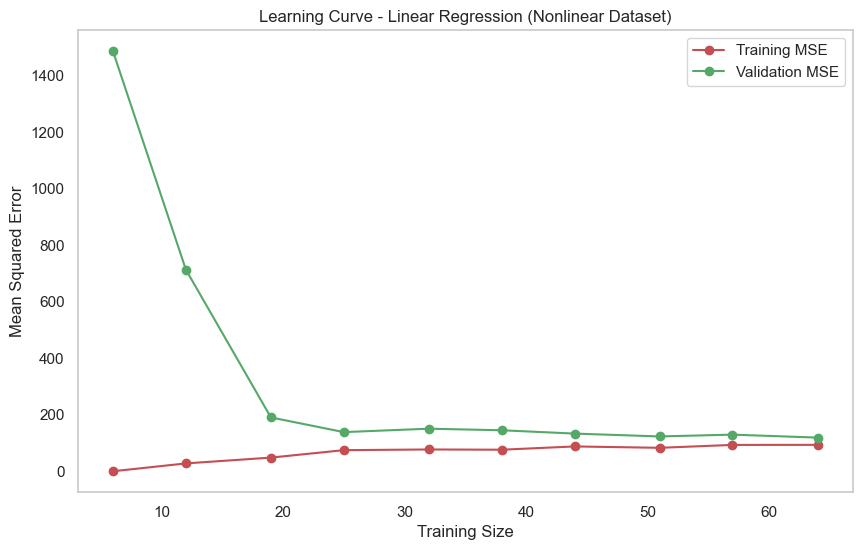

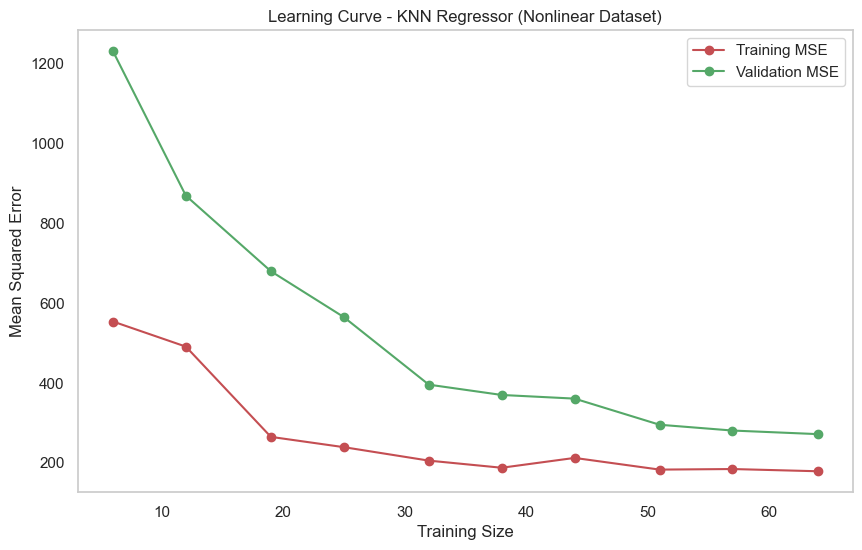

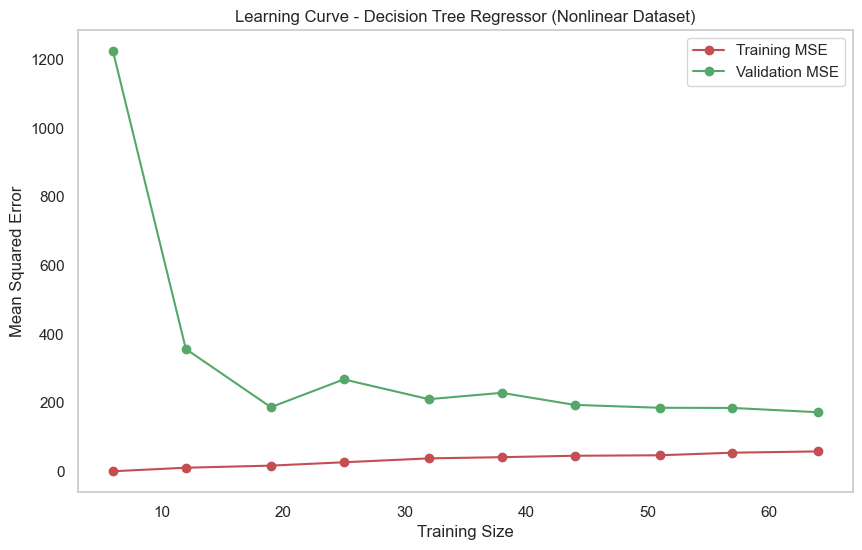

In [22]:
plot_learning_curves(LinearRegression(), X_train_linear, y_train_linear, 'Learning Curve - Linear Regression (Linear Dataset)')

plot_learning_curves(knn_models_linear, X_train_linear, y_train_linear, 'Learning Curve - KNN Regressor (Linear Dataset)')

plot_learning_curves(dt_models_linear, X_train_linear, y_train_linear, 'Learning Curve - Decision Tree Regressor (Linear Dataset)')

plot_learning_curves(LinearRegression(), X_train_nonlinear_poly, y_train_nonlinear, 'Learning Curve - Linear Regression (Nonlinear Dataset)')

plot_learning_curves(knn_models_nl, X_train_nonlinear_poly, y_train_nonlinear, 'Learning Curve - KNN Regressor (Nonlinear Dataset)')

plot_learning_curves(dt_models_nl, X_train_nonlinear_poly, y_train_nonlinear, 'Learning Curve - Decision Tree Regressor (Nonlinear Dataset)')
